In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sn
import xlrd
import operator
import math
import re
import openpyxl
from collections import Counter, defaultdict
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import nltk
from nltk import bigrams

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
#df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > 800]
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...


# Data Info

In [3]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf

SP              2573
PvdA            2269
CDA             2216
D66             2211
VVD             2157
PVV             1880
ChristenUnie    1223
GroenLinks      1193
SGP              770
PvdD             480
50PLUS           413
Name: party, dtype: int64

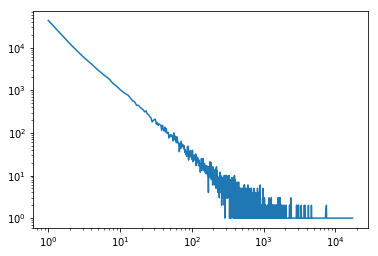

In [4]:
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

803.9600230083405


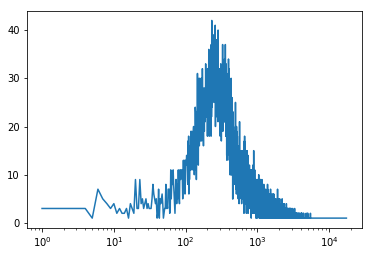

In [5]:
t = [len(doc) for doc in list_text]
meanlength = sum(t)/len(t)
print(meanlength)
t = Counter(t)
t = sorted(t.items())
x, y = zip(*t)
plt.semilogx(x, y)
plt.show()

# Baseline

In [6]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       413
         CDA       0.12      0.12      0.12      2216
ChristenUnie       0.06      0.06      0.06      1223
         D66       0.13      0.13      0.13      2211
  GroenLinks       0.07      0.07      0.07      1193
         PVV       0.11      0.11      0.11      1880
        PvdA       0.13      0.13      0.13      2269
        PvdD       0.02      0.02      0.02       480
         SGP       0.04      0.04      0.04       770
          SP       0.15      0.15      0.15      2573
         VVD       0.13      0.13      0.13      2157

 avg / total       0.11      0.11      0.11     17385



In [7]:
accuracy_score(df.party, np.full(len(df.party), countdf.idxmax()))

0.14800115041702616

# Models

In [8]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [9]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [10]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')
print(pipe.steps)

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1.0,
        vocabulary=None)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5.0, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))
print('Accuracy: ', accuracy_score(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.98      0.89      0.93        92
         CDA       0.81      0.81      0.81       449
ChristenUnie       0.89      0.83      0.86       235
         D66       0.80      0.80      0.80       456
  GroenLinks       0.92      0.76      0.83       241
         PVV       0.83      0.83      0.83       387
        PvdA       0.76      0.79      0.78       458
        PvdD       0.92      0.89      0.90        90
         SGP       0.91      0.92      0.92       164
          SP       0.77      0.84      0.81       490
         VVD       0.80      0.80      0.80       415

 avg / total       0.82      0.82      0.82      3477

Accuracy:  0.820247339660627


In [14]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,SP,PvdA,CDA,D66,VVD,PVV,ChristenUnie,GroenLinks,SGP,PvdD,50PLUS
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,lid ouwehand naar,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,leden van veldhoven,lid van tongeren,de pvv,pvda,het lid ouwehand,de sgp,de sp,vvd
2,lid krol,cda fractie,het lid dik,mijn fractie,leden van tongeren,klever,van de arbeid,lid ouwehand,de leden dijkgraaf,sp fractie,de vvd is
3,het lid krol,de cda fractie,lid dik,d66 is,de leden voortman,islamitische,de arbeid,ouwehand naar mij,leden dijkgraaf,de sp fractie,vvd is
4,krol naar mij,de cda,lid dik faber,lid van veldhoven,leden voortman,agema naar mij,de partij van,ouwehand naar,sgp fractie,lid van gerven,vvd fractie
5,krol naar,het lid omtzigt,de leden voordewind,d66 wil,het lid voortman,madlener naar mij,partij van de,de dieren,de sgp fractie,smaling,de vvd fractie
6,van 50plus,lid omtzigt,leden voordewind,van veldhoven,lid voortman,agema naar,partij van,voor de dieren,leden van der,lid smaling,voor de vvd
7,krol,lid omtzigt naar,leden dik,veldhoven,lid voortman naar,madlener naar,arbeid,dieren,mevrouw de voorzitter,het lid smaling,wat de vvd
8,gepensioneerden,omtzigt naar mij,de leden dik,lid van meenen,voortman,pvv fractie,pvda fractie,ouwehand,mevrouw de,lid smaling naar,de vvd betreft
9,50plus is,omtzigt naar,leden dik faber,d66 vindt,tongeren,klever naar mij,de pvda fractie,thieme,de leden bisschop,het lid leijten,vvd betreft


In [15]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

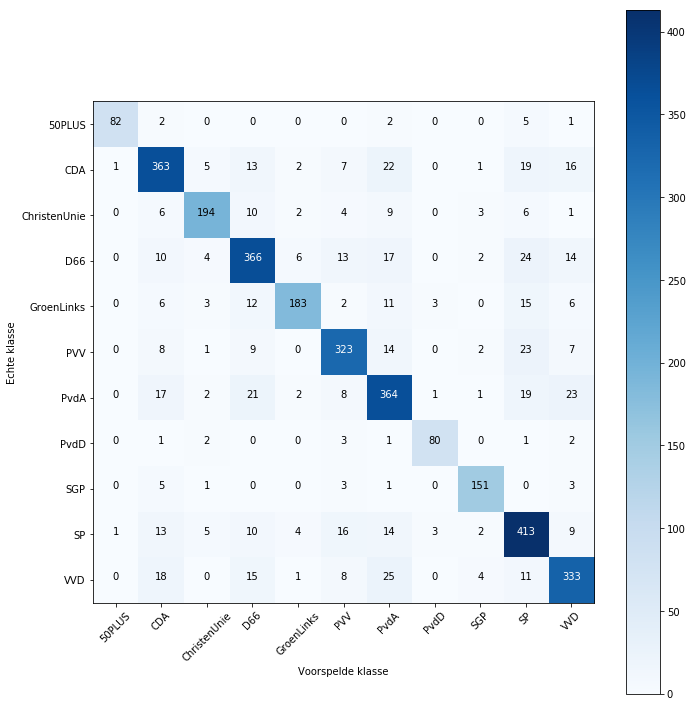

In [16]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [17]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text,withoutnames
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [18]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.89      0.59      0.71        87
         CDA       0.69      0.53      0.60       439
ChristenUnie       0.77      0.48      0.59       243
         D66       0.55      0.63      0.59       413
  GroenLinks       0.67      0.45      0.54       226
         PVV       0.68      0.79      0.73       388
        PvdA       0.67      0.54      0.60       477
        PvdD       0.78      0.77      0.77        81
         SGP       0.78      0.79      0.79       184
          SP       0.57      0.72      0.64       500
         VVD       0.53      0.70      0.60       439

 avg / total       0.65      0.63      0.63      3477



In [19]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,SP,PvdA,CDA,D66,VVD,PVV,ChristenUnie,GroenLinks,SGP,PvdD,50PLUS
0,gepensioneerd,inwoner,inderdad,mijn fractie,zou,islamitisch,kinder,dier,mevrouw de voorzitter,huurder,volgen mij
1,plusser,partijnaam fractie,gezinn,mijn,schon energie,brussel,mijn partij,milieu,mevrouw de,zegt,ondernemer
2,ouder,partijnaam,voedselverspill,natur,in elk geval,nederland,jonger,de natur,dank zer,bezuin,partijnaam
3,50 plusser,reger,geestelijk,daarom,elk geval,miljard,hun,bio industrie,punt,herindel,aangegev
4,koopkrachtontwikkel,de reger,rechtsstat,vandag,schon,al,sam,industrie,wel,bestuurder,volgen
5,50,hier,mensenhandel,buitengewon,kamer hierover te,belastingbetaler,die,de bio,nadruk,de bevolk,partijnaam fractie
6,werkend,antwoord,zull,hervorm,in elk,de islam,tevred,de aard,eenverdiener,bevolk,liberal
7,ouderenwerklos,de nederland spoorweg,zoutwinn,kans,werkgeleg,asielzoeker,gezamen,constater dat,dank,tenderned,regelgev
8,vor gepensioneerd,spoorweg,elkar,fractie,bewindsperson,islam,open standaard,bio,vor de beantwoord,mens,zijn
9,overweg dat,nederland spoorweg,motie,het kabinet,bezuin,dit kabinet,all,aard,allerlei,segregatie,speelveld


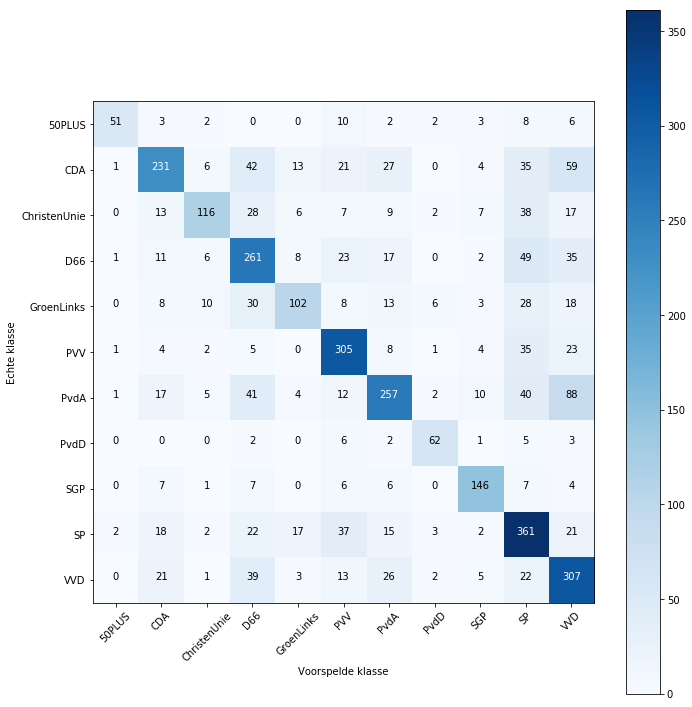

In [20]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Regering & Oppositie

In [21]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.PartijStatus)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.PartijStatus, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


             precision    recall  f1-score   support

  Oppositie       0.82      0.97      0.89      2219
   Regering       0.85      0.45      0.59       882

avg / total       0.83      0.82      0.80      3101



In [22]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,die
1,partij
2,all
3,volgen mij
4,toezegg
5,partijnaam is
6,heb
7,tevred
8,wij
9,beter


In [23]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,terwijl
1,zou
2,bezuin
3,staatssecretaris
4,eigen
5,toch
6,mijn fractie
7,waarom
8,zegt
9,minister


# Woorden Balkenende 4

In [24]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...


In [25]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1348
ChristenUnie     674
D66              623
GroenLinks       901
PVV             1143
PvdA            1204
PvdD             215
SGP              570
SP              1499
VVD             1323
Name: party, dtype: int64

In [26]:
Party_synomyns
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
dfb4['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,withoutnames
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...,voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...,mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...,mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...,mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...,mevrouw de voorzitter zer vel dank vor het ver...


In [27]:
pipe, _ = getbestpipe('Scores.csv')
dfb4_train = dfb4.sample(frac=0.8)
dfb4_test_index = list(set(dfb4.index.tolist()) - set(dfb4_train.index.tolist()))
dfb4_test = dfb4[dfb4.index.isin(dfb4_test_index)]
pipe.fit(list(dfb4_train.withoutnames), list(dfb4_train.party))
predicted = pipe.predict(dfb4_test.withoutnames)
print(classification_report(dfb4_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.55      0.67      0.61       249
ChristenUnie       0.63      0.44      0.52       138
         D66       0.71      0.50      0.59       123
  GroenLinks       0.61      0.57      0.59       192
         PVV       0.57      0.68      0.62       236
        PvdA       0.56      0.41      0.48       233
        PvdD       0.72      0.48      0.58        60
         SGP       0.65      0.91      0.76       116
          SP       0.59      0.62      0.61       306
         VVD       0.44      0.45      0.44       247

 avg / total       0.58      0.57      0.57      1900



In [28]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,partijnaam fractie,fractie van partijnaam,hervorm,partijnaamfractie,burger,wij,dier,mijn fractie,zegt,onz fractie
1,wij,de fractie van,arbeidsmarkt,fractie van partijnaam,immigratie,vrouw,dierproev,wel,lerar,partijnaam
2,buitengewon,de fractie,schon energie,de fractie van,natur,wet,bio industrie,helder,bezuin,partijnaam fractie
3,fractie,fractie van,dadelijk,de fractie,onz,kinder,de bio industrie,diver,bureaucratie,fractie
4,via,coalitieakkoord,welk,mij,de burger,volgen mij,de bio,toch,nu,ondernemer
5,partijnaam fractie heeft,mijn fractie,de arbeidsmarkt,deal,niet,all,bio,bewindslied,niet,echt
6,aangegev,het coalitieakkoord,patient,fractie van,belastinggeld,beoordel,de veehouderij,de bewindslied,student,in elk
7,zorgvrager,partijnaamfractie,premier,politiek,dor,iederen,de dier,allerlei,problem,kamerlidnaamman
8,toezegg,geweest,ik hop,klimaatverander,dez,geweld,zes,beantwoord,personel,in elk geval
9,element,de vrag ik,de premier,premier,gewon,belangrijk,aan de bio,uitdruk,verdrag,elk geval


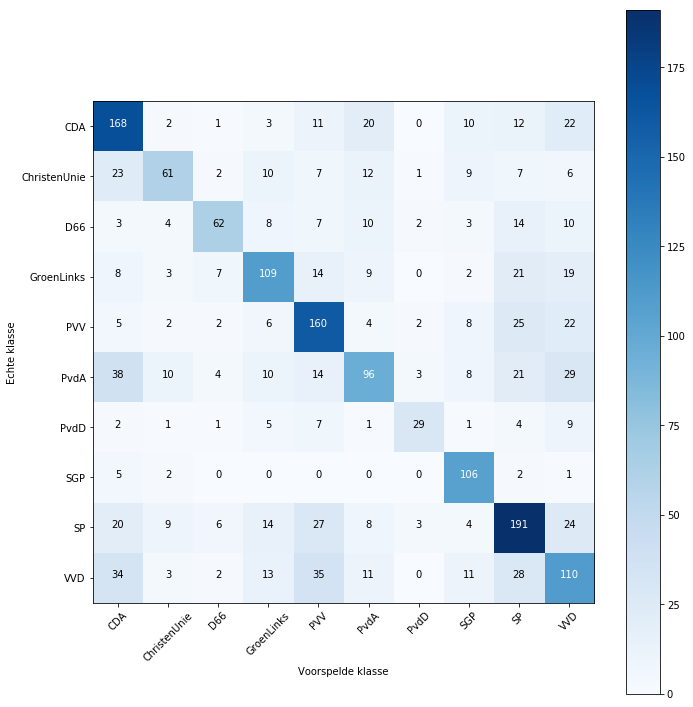

In [29]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dfb4_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(dfb4.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Vergelijken

In [30]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(tempdf.withoutnames, tempdf.party)
predicted = pipe.predict(dfb4.withoutnames)
print(classification_report(dfb4.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.31      0.28      0.29      1348
ChristenUnie       0.44      0.22      0.30       674
         D66       0.20      0.25      0.22       623
  GroenLinks       0.19      0.05      0.08       901
         PVV       0.46      0.63      0.53      1143
        PvdA       0.32      0.35      0.33      1204
        PvdD       0.62      0.52      0.57       215
         SGP       0.51      0.60      0.55       570
          SP       0.44      0.53      0.48      1499
         VVD       0.20      0.21      0.21      1323

 avg / total       0.34      0.36      0.34      9500



In [31]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(dfb4.withoutnames, dfb4.party)
predicted = pipe.predict(tempdf.withoutnames)
print(classification_report(tempdf.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.21      0.26      0.23      2216
ChristenUnie       0.28      0.15      0.20      1223
         D66       0.25      0.18      0.21      2211
  GroenLinks       0.17      0.06      0.08      1193
         PVV       0.48      0.61      0.54      1880
        PvdA       0.34      0.33      0.33      2269
        PvdD       0.75      0.25      0.38       480
         SGP       0.55      0.45      0.49       770
          SP       0.33      0.64      0.43      2573
         VVD       0.24      0.14      0.18      2157

 avg / total       0.32      0.33      0.30     16972



# Links / Rechts vergelijken

In [32]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push